# How to optimize Mølmer–Sørensen gates for a multitone global beam
**Creating efficient gates for trapped ions without individually addressing the ions**

Boulder Opal equips you to efficiently optimize trapped-ion gates that use Mølmer–Sørensen interactions.
These gates use the vibrational modes of the ion chain to mediate the interaction between the ions, leaving the qubits in an entangled state and restoring the motional state after the operation.

Mølmer–Sørensen-type operations can be performed using either individual addressing of each ion, or a global beam that interacts with all the ions in the chain.
The current user guide shows how to perform the optimization in the case of a global beam with multiple tones.
In other words, the control problem we consider here is one where the interaction Hamiltonian is of the form:

$$
H(t) = i\frac{\hbar}{2} \sum_{j=1}^N \sigma_{x, j} \sum_{p=1}^{3N} \sum_{k=1}^M \eta_{kpj} \left\{ \gamma^{(k)}(t) e^{i \delta_{kp} t} a_{p}^\dagger - \left[ \gamma^{(k)} (t) \right]^* e^{-i \delta_{kp} t} a_p \right\},
$$

where $N$ is the number of ions, $M$ is the number of tones in the global beam, and $a_p$ is the annihilation operator for the p-th mode of oscillation of the chain.
The parameters $\delta_{kp}$ indicate the relative detuning between the k-th tone of the global beam and the p-th mode of oscillation, and the $\eta_{kpj}$ are the Lamb–Dicke parameters for the k-th tone, p-th mode of oscillation, and j-th ion.
These two set of parameters are provided by you as input for the optimization, in order to obtain the controls $\gamma^{(k)}(t)$ for the k-th tone of the global beam.

For more information about the theory behind Mølmer-Sørensen gates, see the user guide [How to optimize error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions).
There you find an introduction to the Mølmer–Sørensen gates and information about how to optimize them both for the case of a global single-tone beam, and for the more flexible case with individual ion addressing.

## Summary workflow

### 1. Define and calculate ion trap properties

Pass the parameters of the ion chain to `boulderopal.ions.obtain_ion_chain_properties` and obtain the Lamb–Dicke parameters and relative detunings associated with each of the vibrational modes.
Note that the Lamb–Dicke parameters and frequencies might be different for each of the tones of the global beam; these should be calculated using a separate function evaluation for each tone with a distinct wave number.

### 2. Optimize drives

Inside a graph, define individual optimizable drives for each of the tones of the system.
Use the tones to calculate the relative phases obtained between each ion, and the displacements of each motional mode due to the drives.
The node `graph.ions.ms_phases_multitone`, which returns the relative phases, accepts Lamb-Dicke parameters and relative detunings for all the tones of the beam. In contrast, the node `graph.ions.ms_displacements` calculates the displacements for one tone at a time.
After all the displacements have been calculated, you can add them together to obtain the total mode displacements due to all the tones.

The performance or fidelity of the gate is determined by the final relative phases and mode displacements; the result of the phase and displacement calculations is thus passed to `graph.ions.ms_infidelity`, in order to obtain the cost function for optimal controls.
(You can add the contribution from `graph.ions.ms_dephasing_robust_cost` if you want to build error-robust gates, as shown in the user guide [How to optimize error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions).)

Run this optimization with `boulderopal.run_optimization` to obtain the optimal drives.

## Example: Optimal controls to perform a Mølmer–Sørensen gate with a two-tone global beam.

The following example creates optimal two-tone global drives to maximally entangle a two-ion chain.
At the end, the drives obtained are plotted.

In [1]:
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

In [2]:
# Define parameters of the ion trap.
ion_count = 2
atomic_mass = 171  # Yb ions.
center_of_mass_frequencies = [1.6e6, 1.5e6, 0.3e6]

# Define laser parameters.
maximum_rabi_rate = 2 * np.pi * 50e3  # Hz
laser_detuning = 1.6e6 + 4.7e3  # Hz

# Define gate parameters.
duration = 3e-4  # s
target_phases = np.array([[0, 0], [np.pi / 4, 0]])
segment_count = 64

In [3]:
# Obtain setup parameters for the two tones.
lamb_dicke_parameters_1, relative_detunings_1, *_ = bo.ions.obtain_ion_chain_properties(
    atomic_mass=atomic_mass,
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=[2 * np.pi * 2.0 / 355e-9, 0, 0],
    laser_detuning=laser_detuning,
).values()

lamb_dicke_parameters_2, relative_detunings_2, *_ = bo.ions.obtain_ion_chain_properties(
    atomic_mass=atomic_mass,
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=[2 * np.pi * 2.4 / 355e-9, 0, 0],
    laser_detuning=laser_detuning,
).values()

In [4]:
graph = bo.Graph()

# Define drive for the first tone.
ion_drive_1 = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count,
    maximum=maximum_rabi_rate,
    duration=duration,
    name=r"$\gamma^{(1)}$",
)

# Define drive for the second tone.
ion_drive_2 = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count,
    maximum=maximum_rabi_rate,
    duration=duration,
    name=r"$\gamma^{(2)}$",
)

# Calculate phases due to both drives.
ms_phases = graph.ions.ms_phases_multitone(
    drives=[ion_drive_1, ion_drive_2],
    lamb_dicke_parameters=np.array([lamb_dicke_parameters_1, lamb_dicke_parameters_2]),
    relative_detunings=np.array([relative_detunings_1, relative_detunings_2]),
    name="phases",
)

# Calculate displacements due to each drive, which is applied to both ions.
ms_displacements_1 = graph.ions.ms_displacements(
    drives=[ion_drive_1] * ion_count,
    lamb_dicke_parameters=lamb_dicke_parameters_1,
    relative_detunings=relative_detunings_1,
)
ms_displacements_2 = graph.ions.ms_displacements(
    drives=[ion_drive_2] * ion_count,
    lamb_dicke_parameters=lamb_dicke_parameters_2,
    relative_detunings=relative_detunings_2,
)

# Calculate total infidelity due to the phases and both displacement contributions.
infidelity = graph.ions.ms_infidelity(
    phases=ms_phases,
    displacements=ms_displacements_1 + ms_displacements_2,
    target_phases=target_phases,
    name="infidelity",
)

# Run optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=[r"$\gamma^{(1)}$", r"$\gamma^{(2)}$", "phases"],
    optimization_count=4,
)

Target phase:    0.7853981634
Optimized phase: 0.7853981501
Optimization cost: 1.332e-15


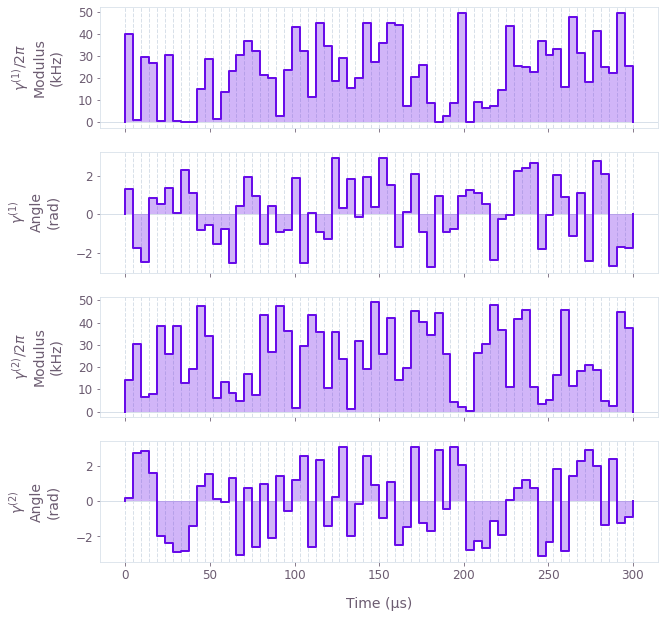

In [5]:
# Print phases and cost.
print(f"Target phase:    {target_phases[1][0]:.10f}")
print(f"Optimized phase: {result['output'].pop('phases')['value'][1][0]:.10f}")
print(f"Optimization cost: {result['cost']:.3e}")

# Plot optimized drives.
qv.plot_controls(result["output"])